In [1]:
import numpy as np

from tokenization import make_cfn
from model_wrappers import Classifier
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from random import seed, shuffle
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from matplotlib import pyplot as plt
import pickle

from tqdm import tqdm

DEVICE = 'cuda'
NUM_EPOCHS = 15

with open('../data/tokenized.p', 'rb') as f:
    (tokenized, classes) = pickle.load(f)
tokenized = [(nom, tokens, label) for nom, tokens, label in tokenized if len(tokens) <= 120]
seed(42)
shuffle(tokenized)
print(f'Read {len(tokenized)} data points with {(nc := len(set(y for _, _, y in tokenized)))} classes.')
split_point = int(len(tokenized) * 0.75)
train, dev = tokenized[:split_point], tokenized[split_point:]
print(f'Training on {len(train)} entries, evaluating on {len(dev)}.')

train_dl = DataLoader([(ts, y) for _, ts, y in train], batch_size=32, shuffle=True, collate_fn=make_cfn(DEVICE))  # noqa
dev_dl = DataLoader([(ts, y) for _, ts, y in dev], batch_size=512, shuffle=False, collate_fn=make_cfn(DEVICE))  # noqa

output = []
f1s = []
for it in range(3):
    model = Classifier(nc, False).to(DEVICE)
    optim = AdamW(model.parameters(), lr=5e-5)
    best_loss, best_epoch = 1e10, 0
    for epoch in tqdm(range(NUM_EPOCHS)):
        model.train()
        _ = model.train_epoch(train_dl, optim)
        with torch.no_grad():
            model.eval()
            epoch_loss, _, _ = model.eval_epoch(dev_dl)
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_epoch = epoch
            torch.save(model.state_dict(), f'../data/weights_{it}.pt')

    print(f'Best epoch was {best_epoch}')
    model.load_state_dict(torch.load(f'../data/weights_{it}.pt'))
    with torch.no_grad():
        model.eval()
        epoch_loss, predictions, truth = model.eval_epoch(dev_dl)
    print(f'\tDev loss: {epoch_loss}')
    print(f'\tDev F1 (M): {f1_score(truth, predictions, average="macro")}')
    print(f'\tDev F1 (m): {f1_score(truth, predictions, average="micro")}')
    print(f'\tDev F1 (-): {(f1 := f1_score(truth, predictions, average=None))}')
    f1s.append(f1)
    output.append(predictions)


with open('../data/results.pt', 'wb') as f:
    pickle.dump((dev, output), f)

Read 6192 data points with 9 classes.
Training on 4644 entries, evaluating on 1548.


100%|██████████| 15/15 [01:06<00:00,  4.41s/it]


Best epoch was 13
	Dev loss: 6.906364679336548
	Dev F1 (M): 0.3391566759778526
	Dev F1 (m): 0.4754521963824289
	Dev F1 (-): [0.8959276  0.33281005 0.61044177 0.29711752 0.38327526 0.24
 0.25510204 0.03773585 0.        ]


100%|██████████| 15/15 [01:07<00:00,  4.50s/it]


Best epoch was 14
	Dev loss: 6.794620513916016
	Dev F1 (M): 0.36234391350409434
	Dev F1 (m): 0.4909560723514212
	Dev F1 (-): [0.8952959  0.36193448 0.60921844 0.31700288 0.42461538 0.2721519
 0.24528302 0.13559322 0.        ]


100%|██████████| 15/15 [01:08<00:00,  4.54s/it]


Best epoch was 9
	Dev loss: 6.729186773300171
	Dev F1 (M): 0.332384709811104
	Dev F1 (m): 0.4903100775193798
	Dev F1 (-): [0.89051095 0.36492221 0.56826568 0.29090909 0.45866667 0.2212766
 0.14285714 0.         0.05405405]


In [10]:
f1s = np.array(f1s)

f1_means = f1s.mean(axis=0)
f1_stds = f1s.std(axis=0)
print(f1_means * 100)
print(f1_stds * 200)

[89.39114845 35.32222437 59.59752955 30.16764965 42.21857709 24.44761648
 21.44140675  5.77763565  1.8018018 ]
[ 0.48366635  2.89700976  3.9200038   2.22596618  6.16526456  4.20190799
 10.15138532 11.42814864  5.09626509]
48.557278208441005 1.4322385140668312


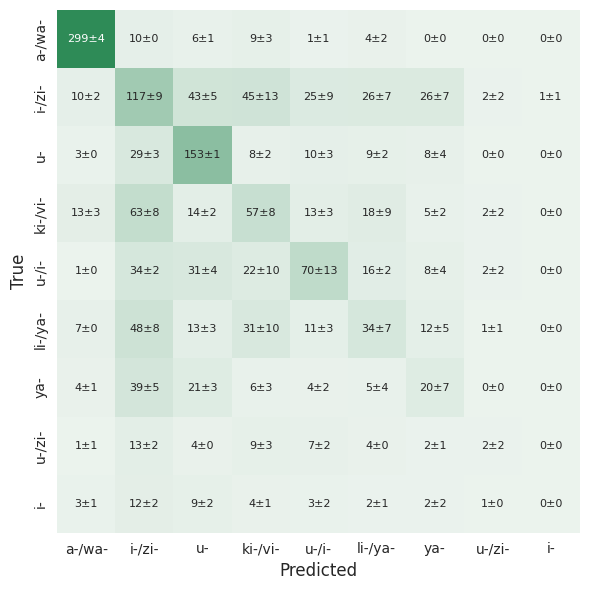

In [5]:
cms = np.array([confusion_matrix(truth, output[i]) for i in range(len(output))])
mus = cms.mean(0)
stds = cms.std(0)
labels = [f'{mu:.0f}±{std:.0f}' for mu, std in zip(mus.flatten(), stds.flatten())]
labels = np.asarray(labels).reshape(mus.shape)
plt.figure(figsize=(6, 6))
sns.heatmap(
    mus,
    annot=labels,
    fmt='',
    cmap=sns.light_palette('seagreen', as_cmap=True),
    xticklabels=classes,
    yticklabels=classes,
    annot_kws={'size': 8},
    cbar=False,
)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.tight_layout()
plt.savefig('../data/trained.pdf')
plt.show()
